<a href="https://colab.research.google.com/github/rodrigosanches21/Sistema_de_Recomendacao/blob/main/Sistema_de_Recomenda%C3%A7%C3%A3o/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
filmes = pd.read_csv('movies.csv', index_col= 'movieId')
filmes.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [ ]:
notas = pd.read_csv('ratings.csv')
notas.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
nota_media = notas.groupby(by='movieId')[['rating']].mean()
nota_media.head()

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


In [ ]:
melhores_filmes = filmes.join(nota_media).sort_values(by='rating', ascending=False)
melhores_filmes.head()

,title,genres,rating
movieId,,,
88448,Paper Birds (Pájaros de papel) (2010),Comedy|Drama,5.0
100556,"Act of Killing, The (2012)",Documentary,5.0
143031,Jump In! (2007),Comedy|Drama|Romance,5.0
143511,Human (2015),Documentary,5.0
143559,L.A. Slasher (2015),Comedy|Crime|Fantasy,5.0


In [ ]:
mais_votados = notas.groupby(by='movieId')[['rating']].count()
mais_votados.rename(columns= {'rating':'qtd_votos'}, inplace=True)
mais_votados.head()

,qtd_votos
movieId,
1,215
2,110
3,52
4,7
5,49


In [ ]:
mais_populares = filmes.join(mais_votados).sort_values(by='qtd_votos', ascending=False)
mais_populares.head()

,title,genres,qtd_votos
movieId,,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War,329.0
318,"Shawshank Redemption, The (1994)",Crime|Drama,317.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307.0
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279.0
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,278.0


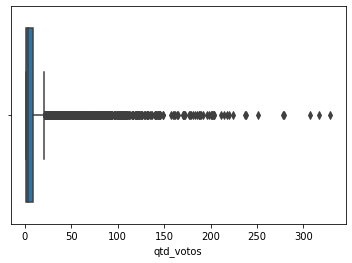

In [ ]:
sns.boxplot(data=mais_populares, x='qtd_votos')

In [ ]:
mais_populares.describe()

,qtd_votos
count,9724.000000
mean,10.369807
std,22.401005
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,329.000000


In [ ]:
melhores_filmes['qtd_votos'] = mais_populares['qtd_votos']
melhores_filmes[melhores_filmes['qtd_votos']>50]

,title,genres,rating,qtd_votos
movieId,,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,4.429022,317.0
858,"Godfather, The (1972)",Crime|Drama,4.289062,192.0
2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.272936,218.0
1276,Cool Hand Luke (1967),Drama,4.271930,57.0
750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.268041,97.0
...,...,...,...,...
172,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller,2.679245,53.0
173,Judge Dredd (1995),Action|Crime|Sci-Fi,2.669355,62.0
432,City Slickers II: The Legend of Curly's Gold (...,Adventure|Comedy|Western,2.645455,55.0


##KNN

In [ ]:
filmes_usuario = notas[notas['userId'] == 1]
filmes_usuario

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
227,1,3744,4.0,964980694
228,1,3793,5.0,964981855
229,1,3809,4.0,964981220
230,1,4006,4.0,964982903


In [ ]:
def distancia(usuario, outro_usuario):
  notas_usuario = notas[notas['userId']==usuario].set_index('movieId')[['rating']]
  notas_outro_usuario = notas[notas['userId']==outro_usuario].set_index('movieId')[['rating']]
  notas_em_comum = notas_usuario.join(notas_outro_usuario, lsuffix='_usuario', rsuffix='_outro_usuario').dropna()
  distancia = np.linalg.norm(notas_em_comum['rating_usuario'] - notas_em_comum['rating_outro_usuario'])
  return distancia


In [ ]:
def knn(usuario,n=5):
  distancias = []
  for outro_usuario in notas['userId'].unique():
    distancias.append([usuario, outro_usuario, distancia(usuario, outro_usuario)])
    distancias_df = pd.DataFrame(distancias, columns=['usuario', 'demais_usuarios', 'distância'])
    distancias_df = distancias_df.drop((distancias_df[distancias_df['demais_usuarios']==usuario]).index)
    distancias_df = distancias_df.sort_values(by='distância').iloc[:n]
  return distancias_df

In [ ]:
knn(1, n=1)

,usuario,demais_usuarios,distância
305,1,306,0.0


In [ ]:
def recomendacoes(usuario):
  usario_mais_proximo = knn(usuario, n=5).index[0]
  filmes_usario_mais_proximo = notas[notas['userId'] == usario_mais_proximo]
  filmes_usario_mais_proximo = filmes_usario_mais_proximo[['movieId', 'rating']].set_index('movieId')

  filmes_usario = notas[notas['userId'] == usuario]
  filmes_usario = filmes_usario[['movieId', 'rating']].set_index('movieId')

  recomendacoes = filmes_usario_mais_proximo.join(filmes_usario,lsuffix='_usario_mais_proximo', rsuffix='_usuario')
  recomendacoes = recomendacoes[recomendacoes['rating_usuario'].isna()].sort_values(by='rating_usario_mais_proximo', ascending=False).iloc[:5].sample()
  return filmes.loc[recomendacoes.index[0]]

In [ ]:
recomendacoes(1)

title                      I, Robot (2004)
genres    Action|Adventure|Sci-Fi|Thriller
Name: 8644, dtype: object

In [ ]:
def recomendacoes_v2(usuario, k=5,n=10):
  usarios_mais_proximos = knn(usuario, n=n).index
  filmes_usarios_mais_proximos = notas.set_index('userId').loc[usarios_mais_proximos]
  filmes_usarios_mais_proximos = filmes_usarios_mais_proximos[['movieId', 'rating']].reset_index().set_index('movieId')

  filmes_usario = notas[notas['userId'] == usuario]
  filmes_usario = filmes_usario[['movieId', 'rating']].set_index('movieId')

  recomendacoes = filmes_usarios_mais_proximos.join(filmes_usario,lsuffix='_usarios_mais_proximos', rsuffix='_usuario')
  recomendacoes = recomendacoes[recomendacoes['rating_usuario'].isna()].sort_values(by='rating_usarios_mais_proximos', ascending=False)
  recomendacoes = recomendacoes.drop('rating_usuario', axis=1).reset_index()

  df = pd.pivot_table(data= recomendacoes, values=['rating_usarios_mais_proximos'], index=['movieId'], columns=['userId'])

  df['media_rating'] = df.apply(func='sum', axis=1)/n
  df = df.sort_values(by='media_rating', ascending=False)
  #filmes.loc[df.index]
  return filmes.loc[df.index].iloc[:k]
  #return df

In [ ]:
recomendacoes_v2(100)

,title,genres
movieId,,
318,"Shawshank Redemption, The (1994)",Crime|Drama
527,Schindler's List (1993),Drama|War
2959,Fight Club (1999),Action|Crime|Drama|Thriller
4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
4022,Cast Away (2000),Drama
